Imports

In [7]:
import os
import pickle
import yaml
import numpy as np
import matplotlib.pyplot as plt
from neurometry.datasets.load_rnn_grid_cells import umap_dbscan

Load pre-trained activations

In [8]:
pretrained_run_id = "20240418-180712"
pretrained_run_dir = os.path.join(
    os.getcwd(),
    f"logs/rnn_isometry/{pretrained_run_id}",
)

pretrained_activations_file = os.path.join(pretrained_run_dir, "ckpt/activations/activations-step25000.pkl")
with open(pretrained_activations_file, "rb") as f:
    pretrained_activations = pickle.load(f)

pretrained_config_file = os.path.join(pretrained_run_dir, "config.txt")
with open(pretrained_config_file) as f:
    pretrained_config = yaml.safe_load(f)

pretrained_clusters, umap_cluster_labels = umap_dbscan(
    pretrained_activations["v"], pretrained_run_dir, pretrained_config, sac_array=None, plot=False
)

neural_points_pretrained = {}
rate_maps_pretrained = {}
for id in np.unique(umap_cluster_labels):
    rate_maps_pretrained[id] = pretrained_activations["v"][umap_cluster_labels == id]
    neural_points_pretrained[id] = rate_maps_pretrained[id].reshape(len(rate_maps_pretrained[id]), -1).T

/home/facosta/miniconda3/envs/neurometry/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/facosta/miniconda3/envs/neurometry/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Helper functions

In [9]:
model_name = "run_qosfkmq5_s_0=1_sigma_saliency=0.05_x_saliency=0.5_model.pt" 
model_path = os.path.join(os.getcwd(), f"results/trained_models/{model_name}")
print(os.path.exists(model_path))

True


In [14]:
def _get_expt_activations_per_cluster(run_name):
    activations = _load_expt_rate_maps(run_name)["v"]
    neural_points_expt = {}
    rate_maps_expt = {}
    for id in np.unique(umap_cluster_labels):
        rate_maps_expt[id] = activations[umap_cluster_labels == id]
        neural_points_expt[id] = rate_maps_expt[id].reshape(len(rate_maps_expt[id]), -1).T
    return neural_points_expt, rate_maps_expt


def _load_expt_rate_maps(run_name):
    activations_dir = os.path.join(os.getcwd(), "results/activations")
    activations_file = os.path.join(activations_dir, f"{run_name}_activations.pkl")
    with open(activations_file, "rb") as f:
        return pickle.load(f)

def _load_expt_config(run_name):
    configs_dir = os.path.join(os.getcwd(), "results/configs")
    config_file = os.path.join(configs_dir, f"{run_name}.json")

    with open(config_file) as file:
        return yaml.safe_load(file)

Load post-saliency training rate maps ("expt")

In [15]:
run_name = "run_qosfkmq5_s_0=1_sigma_saliency=0.05_x_saliency=0.5"
posttrained_activation_file_path = os.path.join(os.getcwd(), f'results/activations/{run_name}_activations.pkl')

with open(posttrained_activation_file_path, "rb") as f:
    posttrained_activations = pickle.load(f)

expt_config = _load_expt_config(run_name)
neural_points_expt, rate_maps_expt = _get_expt_activations_per_cluster(run_name)

The dictionary keys represent the modules:

In [5]:
print(rate_maps_pretrained.keys())
print(rate_maps_expt.keys())

dict_keys([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


Module #8 has 13 neurons, and rate maps with resolution 40 x 40

In [6]:
print(rate_maps_pretrained[8].shape)
print(rate_maps_expt[8].shape)

(13, 40, 40)
(13, 40, 40)


Visualize rate maps for module 8, neuron 10

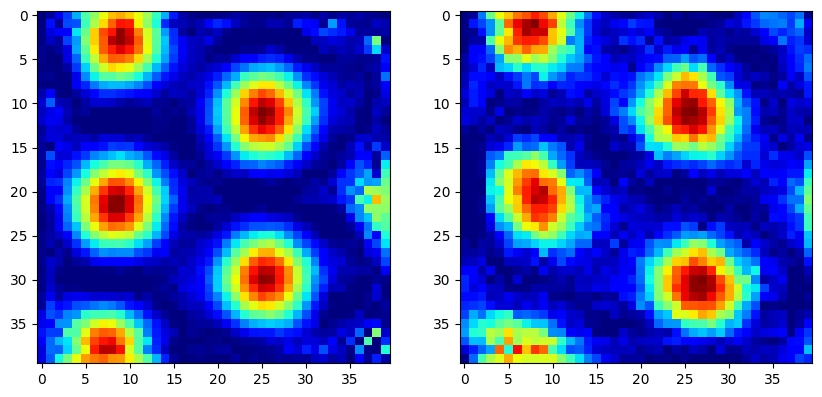

In [47]:
module_id = 6
neuron_id = 5
#visualize both rate maps for cluster 8
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rate_maps_pretrained[module_id][neuron_id],cmap="jet");
plt.subplot(1,2,2)
plt.imshow(rate_maps_expt[module_id][neuron_id],cmap="jet");
plt.show()

## Load post-trained model

In [63]:
import torch
def print_dict_info(d, indent=0):
    for key, value in d.items():
        print("    " * indent + f"{key}: {type(value).__name__}", end="")
        if isinstance(value, dict):
            print()
            print_dict_info(value, indent + 1)
        elif isinstance(value, np.ndarray):
            print(f" (shape: {value.shape})")
        elif torch.is_tensor(value):
            print(f" (shape: {value.shape})")
        else:
            print()

def get_original_index(label, idx_dict_label, labels_array, labels_dict):
    # Initialize the count
    count = 0
    
    # Find the total number of instances for the given label
    total_instances = len(labels_dict[label])
    
    # Iterate through the labels_array to find the matching index
    for idx_original, current_label in enumerate(labels_array):
        if current_label == label:
            if count == idx_dict_label:
                return idx_original
            count += 1

    # If we get here, idx_dict_label was out of bounds for the given label
    raise IndexError(f"idx_dict_label {idx_dict_label} is out of bounds for label '{label}' with {total_instances} instances.")

In [65]:
ckpt = torch.load(model_path, map_location="cuda:2")
print_dict_info(ckpt)

arch: str
state_dict: OrderedDict
    encoder.v: Tensor (shape: torch.Size([1800, 40, 40]))
    decoder.u: Tensor (shape: torch.Size([1800, 40, 40]))
    trans.A_modules: Tensor (shape: torch.Size([150, 12, 12]))
    trans.B_modules: Tensor (shape: torch.Size([1800, 2]))
    trans.b: Tensor (shape: torch.Size([]))


In [25]:
decoder_weights = ckpt["state_dict"]["decoder.u"]

In [27]:
decoder_weights.shape

torch.Size([1800, 40, 40])

umap_cluster_labels contains the module identity of each grid cell:

In [35]:
umap_cluster_labels.shape

(1800,)

In [53]:
print_dict_info(pretrained_clusters)

-1: ndarray (shape: (2, 40, 40))
0: ndarray (shape: (1481, 40, 40))
1: ndarray (shape: (187, 40, 40))
2: ndarray (shape: (17, 40, 40))
3: ndarray (shape: (19, 40, 40))
4: ndarray (shape: (13, 40, 40))
5: ndarray (shape: (11, 40, 40))
6: ndarray (shape: (10, 40, 40))
7: ndarray (shape: (29, 40, 40))
8: ndarray (shape: (13, 40, 40))
9: ndarray (shape: (18, 40, 40))


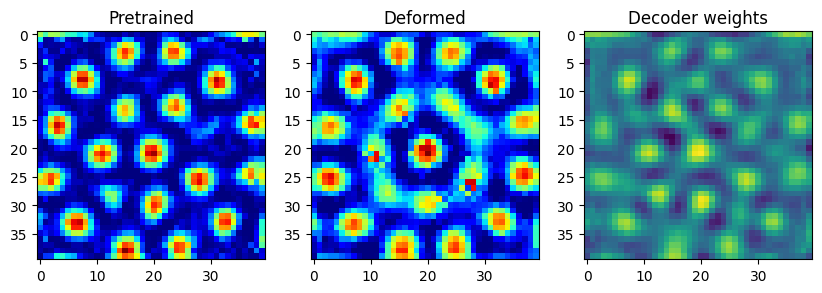

In [73]:
module_id = 8
neuron_id = 10
original_id = get_original_index(module_id, neuron_id, umap_cluster_labels, pretrained_clusters)
#visualize both rate maps for cluster 8
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(rate_maps_pretrained[module_id][neuron_id],cmap="jet");
plt.title("Pretrained")
plt.subplot(1,3,2)
plt.imshow(rate_maps_expt[module_id][neuron_id],cmap="jet");
plt.title("Deformed")
plt.subplot(1,3,3)
plt.imshow(decoder_weights[original_id].cpu(), cmap="viridis");
plt.title("Decoder weights")
plt.show()

In [66]:
pretrained_model_file = os.path.join(pretrained_run_dir, "ckpt/model/checkpoint-step25000.pth")
pretrained_model = torch.load(pretrained_model_file, map_location="cuda:3")
pretrained_model["state_dict"]["decoder.u"].shape
plt.imshow(pretrained_model["state_dict"]["decoder.u"][original_id].cpu(), cmap="viridis");

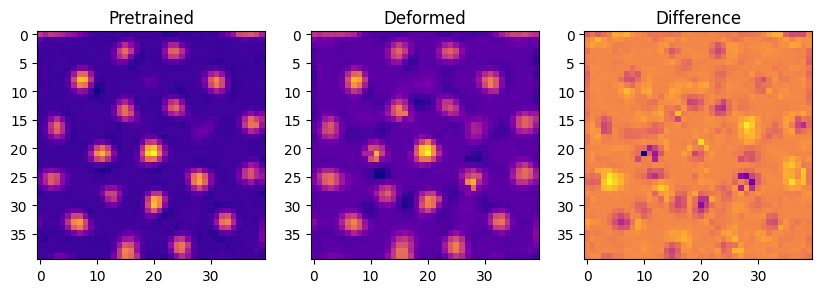

In [84]:
#element-wise multiplication

pretrained_activity_times_weights = rate_maps_pretrained[module_id][neuron_id] * decoder_weights[original_id].cpu().numpy()

deformed_activity_times_weights = rate_maps_expt[module_id][neuron_id] * decoder_weights[original_id].cpu().numpy()


plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(pretrained_activity_times_weights, cmap="plasma");
plt.title("Pretrained")
plt.subplot(1,3,2)
plt.imshow(deformed_activity_times_weights, cmap="plasma");
plt.title("Deformed")
plt.subplot(1,3,3)
plt.imshow(deformed_activity_times_weights-pretrained_activity_times_weights, cmap="plasma");
plt.title("Difference")
plt.show()